In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.datasets as ds
import pylab as plt

In [2]:
def load_mnist(datadir='./data_cache'):
    train_ds = ds.MNIST(root=datadir, train=True,
                           download=True, transform=None)
    test_ds = ds.MNIST(root=datadir, train=False,
                          download=True, transform=None)

    def to_xy(dataset):
        X = np.array(dataset.data) / 255.0  # [0, 1]
        Y = np.array(dataset.targets)
        return X, Y

    X_tr, Y_tr = to_xy(train_ds)
    X_te, Y_te = to_xy(test_ds)
    return X_tr, Y_tr, X_te, Y_te

X_tr, Y_tr, X_te, Y_te = load_mnist()

0it [00:00, ?it/s]

Extracting ./data_cache/MNIST/raw/train-images-idx3-ubyte.gz to ./data_cache/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data_cache/MNIST/raw/train-labels-idx1-ubyte.gz to ./data_cache/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data_cache/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data_cache/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data_cache/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_cache/MNIST/raw
Processing...
Done!


/home/moritz/venvs/mltheory/lib/python3.6/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


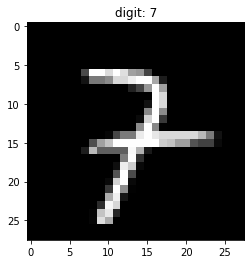

In [3]:
i = np.random.choice(len(X_tr))
plt.imshow(X_tr[i], cmap='gray');
plt.title(f'digit: {Y_tr[i]}');

## Linear Regression

In [4]:
print('original X_tr:', X_tr.shape)

# select 500 random examples
n = 500
I = np.random.choice(len(X_tr), n, replace=False)
X = X_tr[I]
Y = (Y_tr[I] % 2) * 2.0 - 1 # odd/even --> +1/-1
X = X.reshape(-1,  28*28) # flatten

print('reshaped X:', X.shape)
print('reshaped Y:', Y.shape)

original X_tr: (60000, 28, 28)
reshaped X: (500, 784)
reshaped Y: (500,)


Now solve:
$$\text{argmin}_\beta ||X \beta - Y||_2$$
for $\beta \in \mathbb{R}^{784}$

### 0.

In [6]:
rank = np.linalg.matrix_rank(X)
print(f"rank: {rank}")

rank: 500


### 1.

In [18]:
X_pinv = np.linalg.pinv(X)
beta_sol = np.matmul(X_pinv,Y)

# double check:
train_error = np.linalg.norm(np.matmul(X,beta_sol)-Y)**2/Y.shape[0]
print(train_error)

# get the 'test error'
test_error = np.linalg.norm(np.matmul(X_te.reshape(-1,  28*28),beta_sol)-Y_te)**2/Y_te.shape[0]
print(test_error)

3.326192810338168e-28
39.50057070789357


Using the Moore-Penrose pseudo-inverse of X, we did find the least-squares solution to the equation $X \beta=Y$ as confirmed by the low 'train error'. This however does not generalize well (as expected, as it was unlikely that a linear model could capture this problem).

### 2.

$\frac{\partial L}{\partial \beta} = (X^TX)\beta-X^TY$

### 3.